In [4]:
import yt
from yt import YTArray
from yt import YTQuantity

from astropy import constants as const

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import SymLogNorm, LogNorm

import palettable
from palettable.colorbrewer.sequential import Blues_8
import palettable.colorbrewer as brew

In [7]:
folder = 'test'
output = 3

ds = yt.load('~/rusty_data/simulations/kmin_4_kmax_32_alpha_0/tcool_tff_1.0/DD0000/DD0000')

def _drho_over_rho(field, data):
    z = data[('gas', 'z')]
    rho = data[('gas', 'density')]
    print(np.shape(z))
    res = int( abs(z[0] - z[-1]) / abs(z[0] - z[1])) + 1
    drho_over_rho = np.zeros(len(z))
    
    for i in range(res):
        mask = z == z[i]
        ave_rho = np.mean(rho[mask])
        drho_over_rho[mask] = (rho[mask] - ave_rho) / ave_rho
    return drho_over_rho 
    
    
def _accel_z(field, data):
    accel_unit = ds.length_unit.value / ds.time_unit.value**2
    accel = data[('enzo', 'External_Acceleration_z')] * accel_unit
    return YTArray(accel, 'cm/s**2')

def _ff_time(field, data):
    z = data[('gas', 'z')]
    z_midpoint = (z[-1] - z[0]) / 2.0
    z -= z_midpoint
    return np.sqrt(abs(2.0 * z / data[('gas', 'external_acceleration_z')]))

def _cool_ff_ratio(field, data):
    return data[('gas', 'cooling_time')] / data[('gas', 'free_fall_time')]

def _cool_test(field, data):
    L0 =  4.490093e-19
    kb = const.k_B.cgs.value
    rho = data[('gas', 'density')].in_units('g/cm**3')
    T = data[('gas', 'temperature')]
    mu = 1.22
    mh = const.m_p.cgs.value
    
    cool_time = 3*kb * mu * mh * np.power(T, 5./3.) / (2 * rho * L0)
    return YTArray(cool_time.d, 's')

    

def load(output, folder = 'tcool_tff_10'):
    ds = yt.load('~/rusty_data/simulations/%s/DD%04d/DD%04d'%\
                 (folder, output, output))

    #ds.add_field(('gas', 'density_fluctuation'), function = _drho_over_rho, \
    #             display_name = 'Density Fluctuation', units = '')
    ds.add_field(('gas', 'external_acceleration_z'), function = _accel_z, \
                display_name = 'External Acceleration Z', units = 'cm/s**2')

    ds.add_field(('gas', 'free_fall_time'), function = _ff_time, \
                display_name = 'Free Fall Time', units = 's')

    ds.add_field(('gas', 'tcool_tff_ratio'), function = _cool_ff_ratio, \
                display_name = 'Cooling Time / Free Fall Time', units = '')
    ds.add_field(('gas', 'cool_time_test'), function = _cool_test, \
                display_name = 'Cooling Time (test)', units = 'yr')
    
    return ds

def plot_density_slices(ds, folder = '.', half_range = 1.0, rho0 = 1e-27):

    s = yt.SlicePlot(ds, 'x', ('gas', 'density'))
    frb_s = s.frb
    p = yt.ProjectionPlot(ds, 'x', ('gas', 'density'), weight_field = 'ones')
    frb_p = p.frb

    cmap_list = [palettable.cmocean.sequential.Tempo_20.mpl_colormap, \
                 palettable.cmocean.diverging.Curl_9.mpl_colormap]

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(16,14))

    for i, frb in enumerate([frb_s, frb_p]):
        print(i)
        xbins = frb['y'].in_units('kpc')
        ybins = frb['z'].in_units('kpc')
        rho   = frb['density']

        data = rho/rho0

        pcm = ax[i][0].pcolormesh(xbins, ybins, data, norm = LogNorm(), cmap = cmap_list[0], vmin = 1e-1, vmax = 1)
        cbar = fig.colorbar(pcm, ax = ax[i][0], pad=0)
        cbar.set_label('Normalized Density')
        ax[i][0].set_xlabel('y (kpc)')
        ax[i][0].set_ylabel('z (kpc)')


        # calculate density fluctuation                                                                                                  
        data = []
        for rho_slice in rho:
            ave_rho = np.mean(rho_slice)
            data.append((rho_slice - ave_rho) / rho_slice)

        pcm = ax[i][1].pcolormesh(xbins, ybins, data, norm=SymLogNorm(0.01), \
                                  cmap = cmap_list[1], vmin = -half_range, vmax = half_range)
        cbar = fig.colorbar(pcm, ax = ax[i][1], pad=0)
        cbar.set_label('Density Fluctuation')
        ax[i][1].set_xlabel('y (kpc)')
        ax[i][1].set_ylabel('z (kpc)')

    fig.tight_layout()
    plt.show()
    

yt : [INFO     ] 2019-10-12 10:26:33,051 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-12 10:26:33,052 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-12 10:26:33,052 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-12 10:26:33,053 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-12 10:26:33,054 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2019-10-12 12:15:49,053 Parameters: current_time              = 2.4999990395177
yt : [INFO     ] 2019-10-12 12:15:49,053 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-12 12:15:49,054 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-12 12:15:49,055 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-12 12:15:49,056 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-12 12:15:49,106 Gathering a field list (this may take a moment.)
/Users/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/Users/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/Users/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Because 'samp

0.0002608299255371094


yt : [INFO     ] 2019-10-12 12:15:58,055 Projection completed
yt : [INFO     ] 2019-10-12 12:15:58,056 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:15:58,056 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:15:58,059 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:15:58,060 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:15:58,065 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-10-12 12:15:58,193 Making a fixed resolution buffer of (y) 800 by 800
yt : [INFO     ] 2019-10-12 12:15:58,214 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-10-12 12:15:58,231 Making a fixed resolution buffer of (density) 800 by 800


0


yt : [INFO     ] 2019-10-12 12:15:58,445 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-10-12 12:15:58,825 Projection completed
yt : [INFO     ] 2019-10-12 12:15:58,840 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-10-12 12:15:59,180 Projection completed
yt : [INFO     ] 2019-10-12 12:15:59,194 Making a fixed resolution buffer of (density) 800 by 800


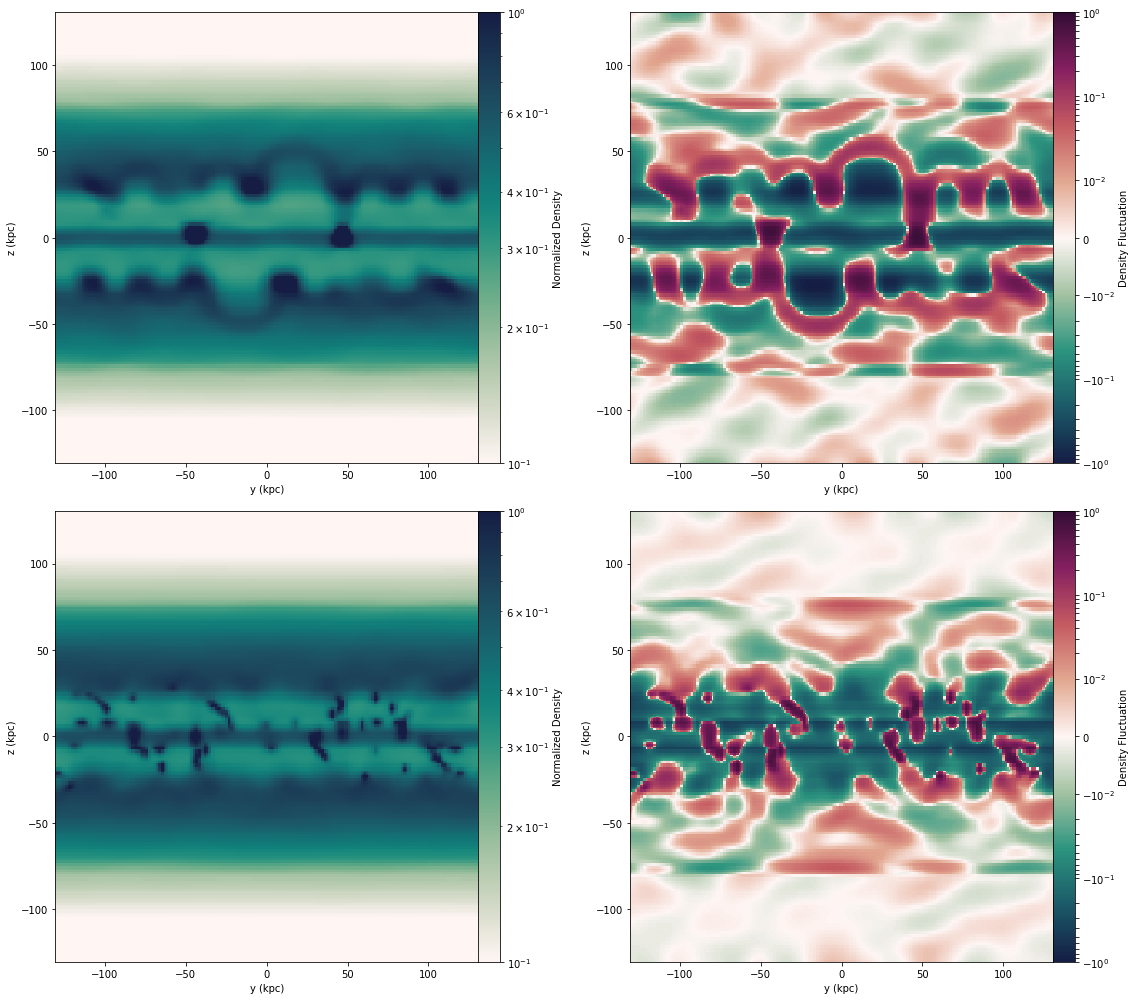


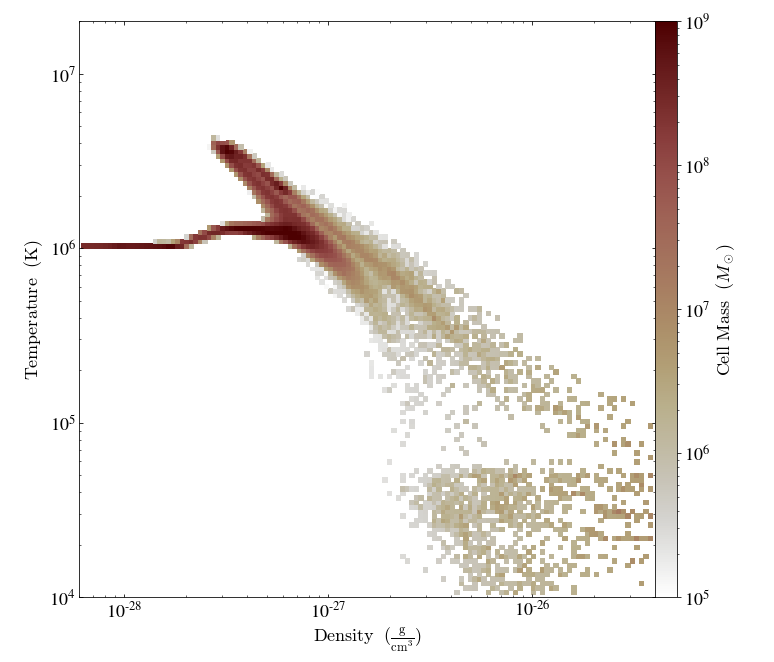

yt : [INFO     ] 2019-10-12 12:16:12,363 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:12,364 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:12,365 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:12,366 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:12,367 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



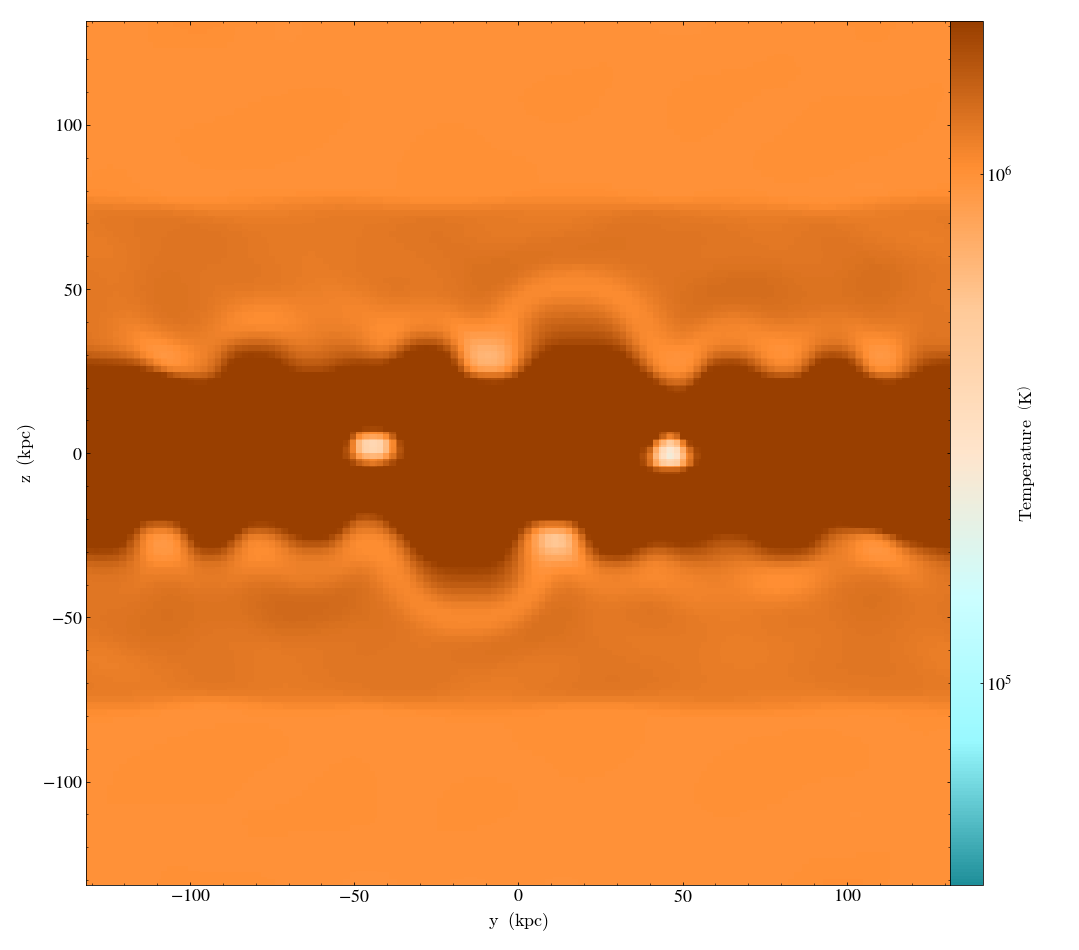

yt : [INFO     ] 2019-10-12 12:16:21,715 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:21,716 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:21,718 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:21,719 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:21,721 Making a fixed resolution buffer of (('gas', 'velocity_z')) 800 by 800
yt : [WARNING  ] 2019-10-12 12:16:21,747 Plot image for field ('gas', 'velocity_z') has both positive and negative values. Min = -5898238.936554, Max = 5357061.084776.
yt : [WARNING  ] 2019-10-12 12:16:21,748 Switching to symlog colorbar scaling unless linear scaling is specified later



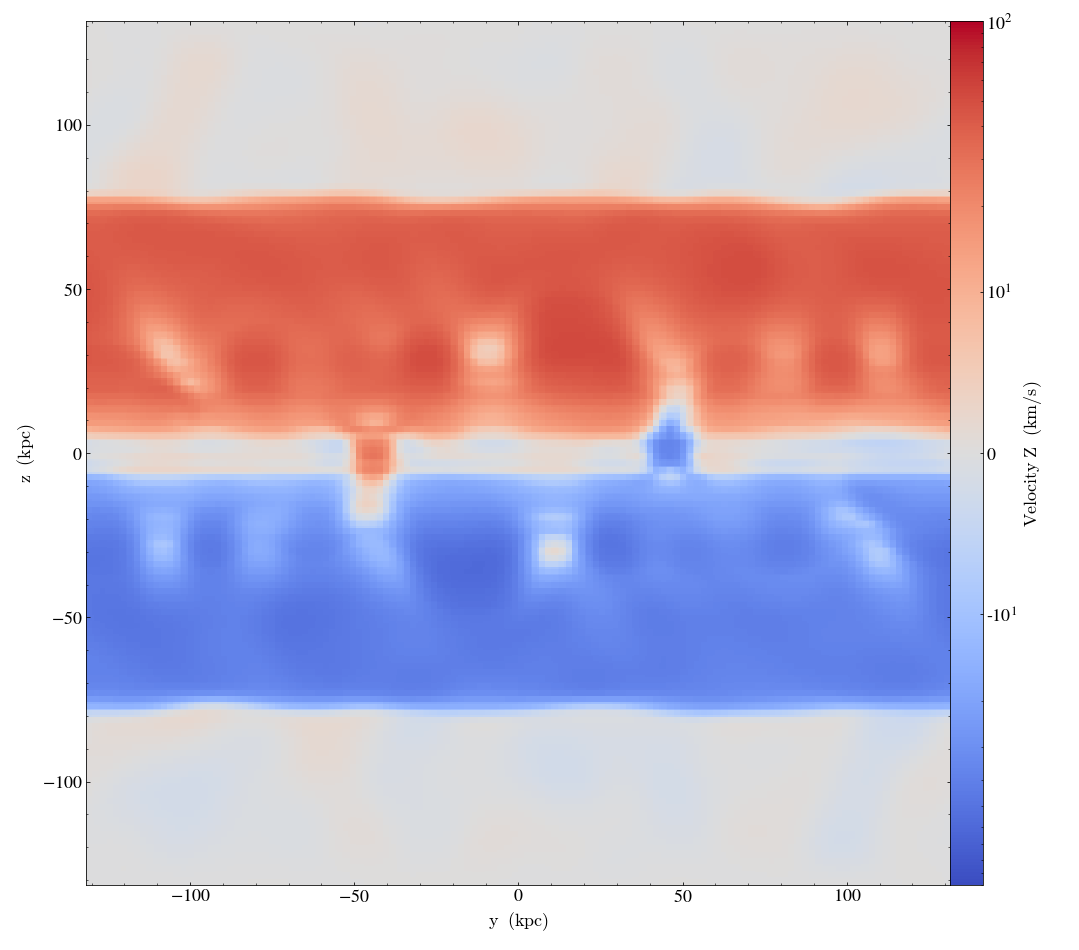

yt : [INFO     ] 2019-10-12 12:16:22,632 Projection completed
yt : [INFO     ] 2019-10-12 12:16:22,632 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:22,633 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:22,634 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:22,635 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-12 12:16:22,637 Making a fixed resolution buffer of (('gas', 'velocity_z')) 800 by 800
yt : [WARNING  ] 2019-10-12 12:16:22,659 Plot image for field ('gas', 'velocity_z') has both positive and negative values. Min = -4305591.327324, Max = 4590286.426495.
yt : [WARNING  ] 2019-10-12 12:16:22,660 Switching to symlog colorbar scaling unless linear scaling is specified later



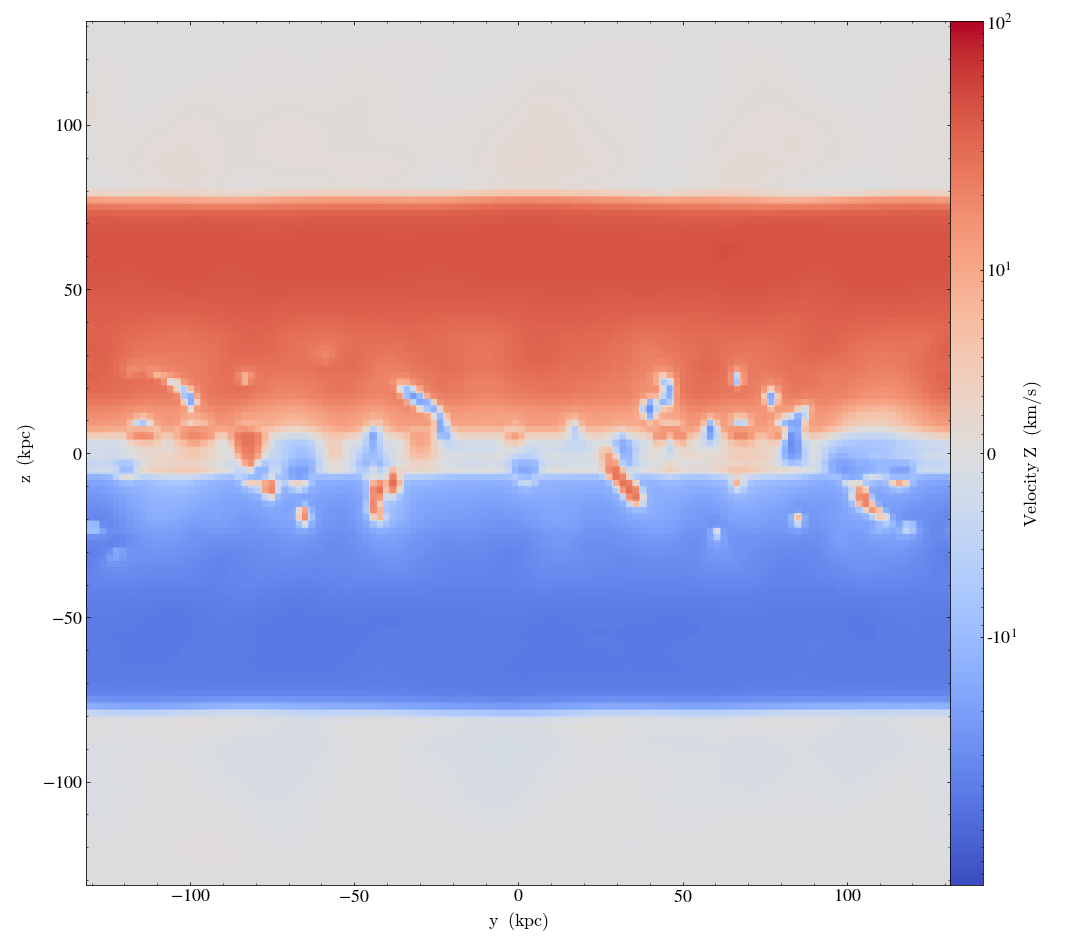

In [62]:
folder = 'isentropic_sf0.01'
#folder = 'isothermal_sf0.01'
folder = 'isothermal'
folder = 'kmin_4_kmax_32_alpha_0/tcool_tff_1.0'
half_range = 1
view = 'x'
for i in [25]:
    ds = load(i, folder = folder)
    ad = ds.all_data()
    rho = ad[('gas', 'density')]
    high_rho = rho[rho > 1e-26]
    print(len(high_rho) / len(rho))

    plot_density_slices(ds, half_range = half_range)
    
    p = yt.PhasePlot(ad, ('gas', 'density'), ('gas', 'temperature'), \
                         ('gas', 'cell_mass'), weight_field = None)
    p.set_xlim(6e-29, 4e-26)
    p.set_ylim(1e4, 2e7)
    p.set_unit(('gas', 'cell_mass'), 'Msun')
    p.set_zlim(('gas', 'cell_mass'), 1e5, 1e9)
    p.set_cmap(('gas', 'cell_mass'), palettable.scientific.sequential.Bilbao_16.mpl_colormap)
    p.show()
        
        

    field = ('gas', 'temperature')
    s = yt.SlicePlot(ds, view, field, window_size = 12)
    s.set_cmap(field, 'coolwarm')
    s.set_zlim(field, 4e4, 2e6)
#    s.set_log(field, False)
    s.set_cmap(field, palettable.lightbartlein.diverging.BlueDarkOrange12_7.mpl_colormap)
    s.show()
    

    field = ('gas', 'velocity_z')
    s = yt.SlicePlot(ds, view, field, window_size = 12)
    s.set_cmap(field, 'coolwarm')
    s.set_unit(field, 'km/s')
    s.set_zlim(field, -100, 100)
    #s.set_zlim(field, -1e7, 1e7)
    #s.set_log(field, False)
    s.show()

    field = ('gas', 'velocity_z')
    s = yt.ProjectionPlot(ds, view, field, window_size = 12, weight_field = 'Density')
    s.set_cmap(field, 'coolwarm')
    s.set_unit(field, 'km/s')
    s.set_zlim(field, -100, 100)
    #s.set_zlim(field, -1e7, 1e7)
    #s.set_log(field, False)
    s.show()


In [58]:
ad = ds.all_data()
cool_time = ad[('gas', 'cooling_time')].in_units('Myr')
cool_test = ad[('gas', 'cool_time_test')].in_units('Myr')

In [60]:
diff = abs(cool_time - cool_test) / cool_time
#diff = diff.reshape(64, 64, 64)
print(max(diff))

1.249775624577799e-06 dimensionless


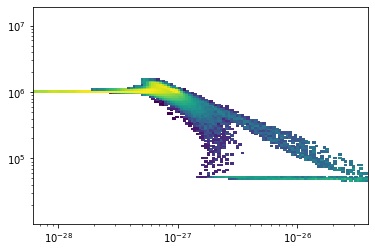

In [57]:
plt.yscale('log')
plt.yscale('log')
plt.pcolormesh(prof.x, prof.y, prof[('gas', 'cell_mass')].T, norm = LogNorm(), vmin = 1e5, vmax = 1e9)

In [32]:
prof = p.profile


In [44]:
prof[('gas', 'cell_mass')]

YTArray([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]) Msun

In [42]:
prof.keys()


dict_keys([('gas', 'cell_mass')])